In [ ]:
Código para separación de pista musical en múltiples instrumentos usando Spleeter

In [28]:
# Ejecutar dentro de línea de comando

from spleeter.separator import Separator

if __name__ == "__main__":
    cancion = "C:\\Users\\AleBe\\Documents\\TT\\intento1\\intento\\utils\\audio.wav"

    separator = Separator("spleeter:4stems")
    separator.separate_to_file(cancion, "C:\\Users\\AleBe\\Documents\\TT\\intento1\\intento\\utils\\audio")
    print("Pista separada")

SpleeterError: ffmpeg binary not found

In [ ]:
Para la ejecución del algoritmo, es necesario procesar el archivo de audio con un solo canal (audio mono).
El siguiente código usa el módulo pydub para lograr esto.

In [70]:
from pydub import AudioSegment

sound = AudioSegment.from_wav("audio1.wav")
sound = sound.set_channels(1)

sound.export("audio1.wav", format="wav")

<_io.BufferedRandom name='audio1.wav'>

In [ ]:
Una vez que el archivo ha sido convertido a monoestereo, vamos a obtener información sobre él.
El primer paso es obtener la información de la pista en el dominio del tiempo. Sin embargo, esto 
todavía no nos da información suficiente para procesar ya que la señal puede contener ruido.

Text(0, 0.5, 'Magnitud')

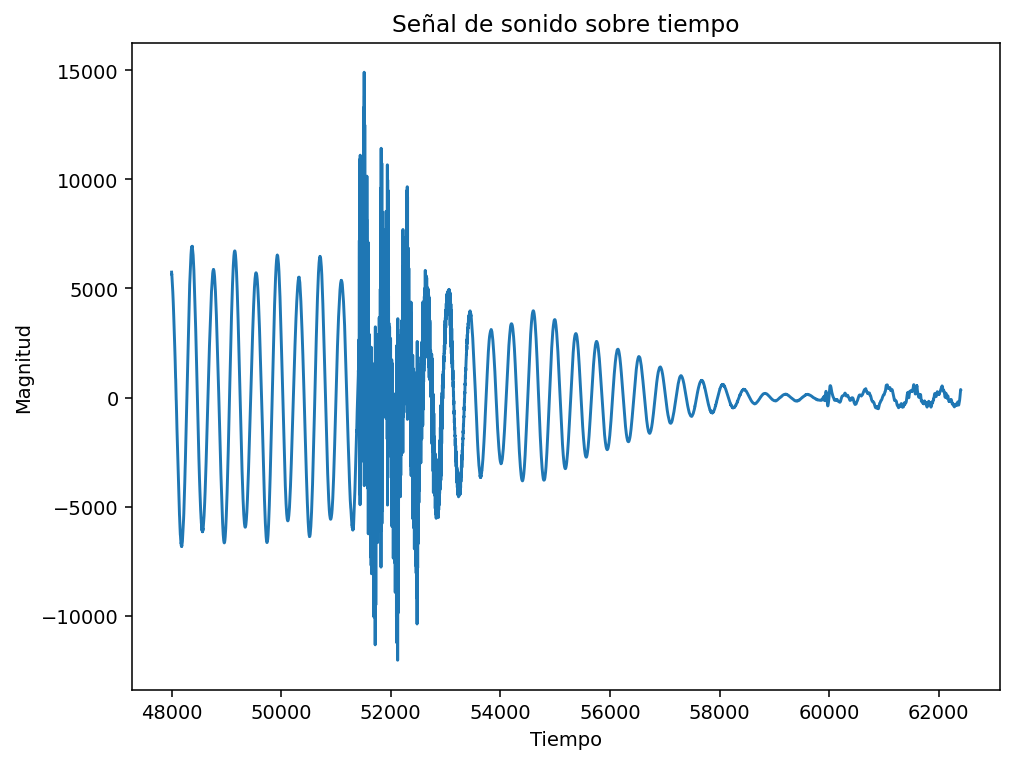

In [71]:
"""Obtener informacion de la pista musical en el tiempo y graficar"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, signal
import scipy
from scipy.io.wavfile import read

# Configuración de la gráfica
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 140

# Leer archivo en format wav
# Fs = frecuencia de sampling del archivo de audio
Fs, song = read("audio1.wav")

# Seleccion de puntos de inicio y finalizacion de la grafica
time_to_plot = np.arange(Fs * 1, Fs * 1.3, dtype=int)
plt.plot(time_to_plot, song[time_to_plot])
plt.title("Señal de sonido sobre tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Magnitud")

In [ ]:
Aplicando la transformada de Fourier a la señal, podemos obtener mayor información acerca de las frecuencias más
relevantes de la señal, sin embargo no contamos con la información de en qué tiempo se presenta cada frecuencia.

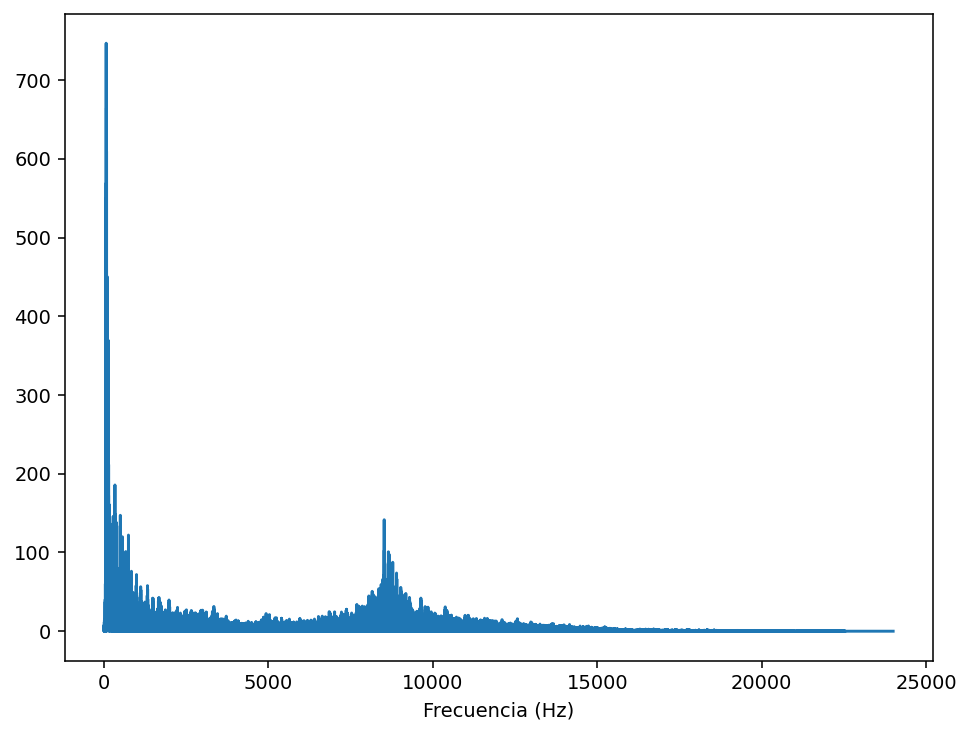

In [72]:
N = len(song)
fft = scipy.fft.fft(song)
transform_y = 2.0 / N * np.abs(fft[0:N//2])
transform_x = scipy.fft.fftfreq(N, 1 / Fs)[:N//2]
plt.plot(transform_x, transform_y)
plt.xlabel("Frecuencia (Hz)");

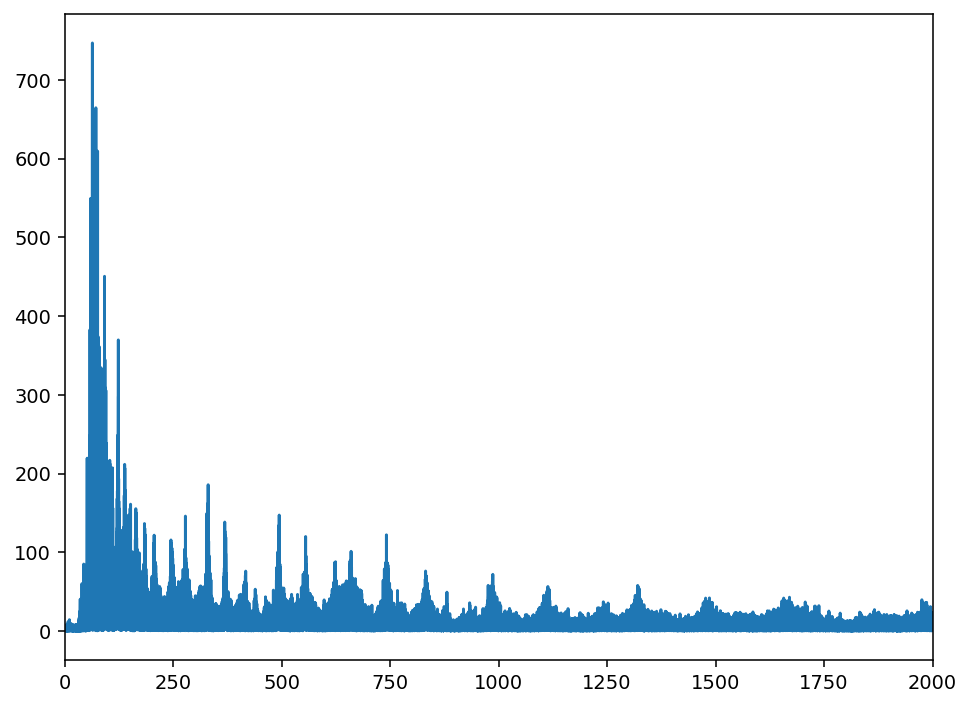

In [73]:
#Señal ampliada

plt.plot(transform_x, transform_y)
plt.xlim(0, 2000);

In [ ]:
Usando sicpy también es posible obtener los n picos más prominentes de la señal, que son fundamentales para
caracterizar la señal con la que se está trabajando.
Sin embargo, las canciones tienden a cambiar su sonido en todo momento, por lo que no es de utilidad analizar todo
el espectro de la canción.

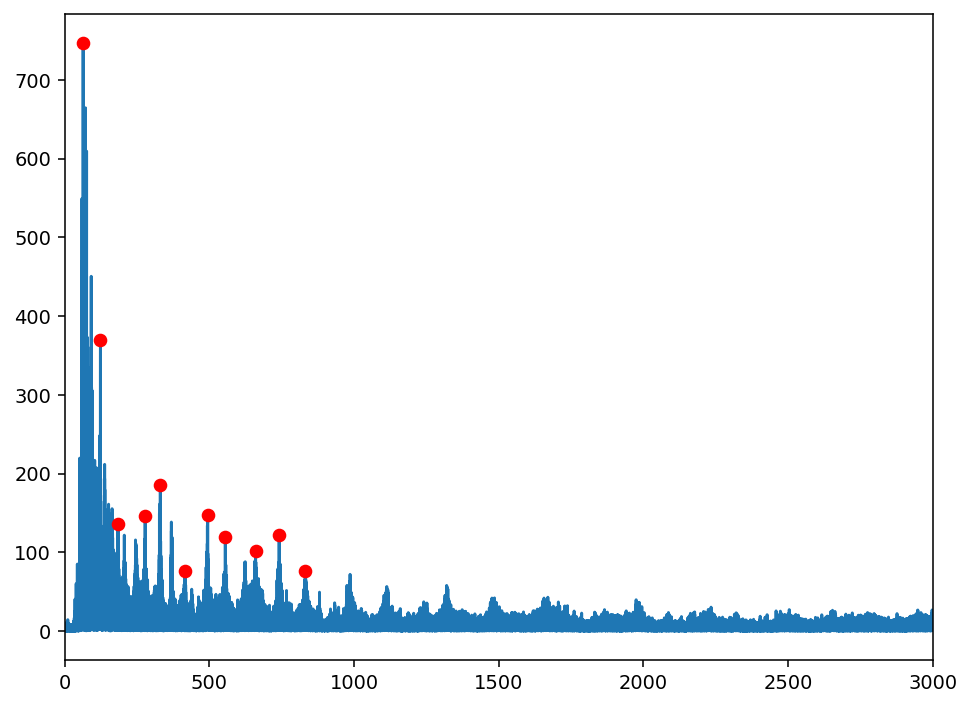

In [74]:
# Usar la función argpartition para encontrar los n-picos más importantes dentro de la señal

todos_los_picos, props = signal.find_peaks(transform_y)

# Encontrar picos con prominencia mínima de 0 y distancia mínima entre picos de 10000
picos, props = signal.find_peaks(transform_y, prominence=0, distance=10000)
n_picos = 15

# Obtener los n_picos picos más grandes a partir de las prominencias
# Explicación útil: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
indices_picos_mas_grandes = np.argpartition(props["prominences"], -n_picos)[-n_picos:]
picos_mas_grandes = picos[indices_picos_mas_grandes]

plt.plot(transform_x, transform_y, label="Espectro")
plt.scatter(transform_x[picos_mas_grandes], transform_y[picos_mas_grandes], color="r", zorder=10, label="Picos Restringidos")
plt.xlim(0, 3000)

plt.show()


In [ ]:
Para resolver este problema, se ha empleado la transformada de Fourier en tiempo corto (desde ahora STFT) para 
obtener un conjunto completo de frecuencias clave a lo largo del tiempo. 

Con esto se podrán hacer coincidir las huellas dactilares del archivo del usuario con cualquier 
punto de la canción.

In [ ]:
Esto se puede lograr empleando la implementación de la STFT del módulo SciPy, que aplica la transformada 
de Fourier en ventanas de tiempo superpuestas.

In [75]:
# Parametros de los snippets
window_length_seconds = 3
window_length_samples = int(window_length_seconds * Fs)
window_length_samples += window_length_samples % 2

# Realizar una transformada de Fourier de tiempo corto
# Frecuencias y tiempos son referencias para graficar/analizar más tarde
# La TFTC es una matriz NxM
frequencies, times, stft = signal.stft(
    song, Fs, nperseg=window_length_samples,
    nfft=window_length_samples, return_onesided=True
)

stft.shape

(72001, 135)

In [ ]:
Posteriormente se realizó la misma búsqueda de picos que antes y los resultados ahora se expresan como los pares 
[tiempo, frecuencia] de la constelación de puntos que caracterizan la canción.

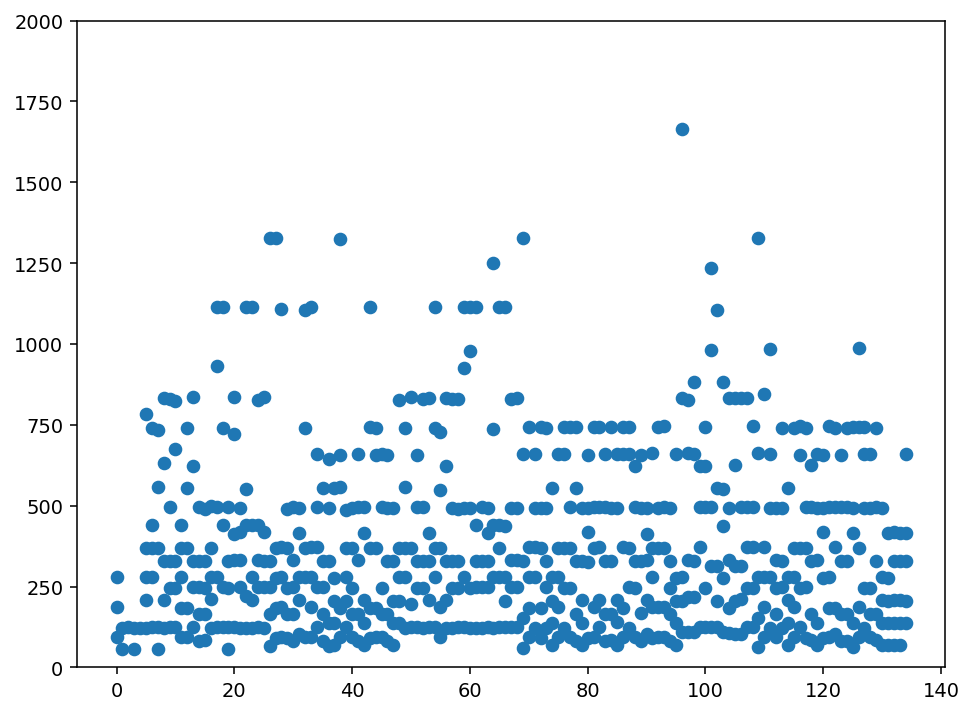

In [77]:
constellation_map = []

for time_idx, window in enumerate(stft.T):
    # Queremos solo valores reales.
    spectrum = abs(window)
    # Los picos corresponden a características interesantes de la señal
    peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)

    # Con un máximo de 5 por segmento de tiempo
    n_peaks = 5
    # Obtener los n picos más grandes a partir de las prominencias
    # Explicación útil de argpartition: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
    largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
    for peak in peaks[largest_peaks]:
        frequency = frequencies[peak]
        constellation_map.append([time_idx, frequency])

# Transformar [(x, y), ...] en ([x1, x2...], [y1, y2...]) para graficar usando zip
plt.scatter(*zip(*constellation_map));
plt.ylim(0, 2000);


In [78]:
# LINEA DE DEBUG, NO AGREGAR AL DOC
print(constellation_map)

[[0, 280.0], [0, 8648.0], [0, 93.33333333333333], [0, 186.33333333333331], [0, 8520.0], [1, 8720.0], [1, 56.0], [1, 8648.0], [1, 123.33333333333333], [1, 8520.0], [2, 8904.0], [2, 8716.0], [2, 8520.0], [2, 123.66666666666666], [2, 8648.0], [3, 8716.0], [3, 8648.0], [3, 8520.0], [3, 122.66666666666666], [3, 56.0], [4, 8904.0], [4, 8716.0], [4, 123.33333333333333], [4, 8520.0], [4, 8648.0], [5, 278.0], [5, 370.3333333333333], [5, 782.6666666666666], [5, 208.66666666666666], [5, 123.33333333333333], [6, 440.0], [6, 740.3333333333333], [6, 278.3333333333333], [6, 369.3333333333333], [6, 124.33333333333333], [7, 56.0], [7, 735.3333333333333], [7, 559.0], [7, 369.66666666666663], [7, 123.66666666666666], [8, 630.6666666666666], [8, 208.66666666666666], [8, 833.0], [8, 329.66666666666663], [8, 122.33333333333333], [9, 496.0], [9, 124.0], [9, 329.3333333333333], [9, 246.33333333333331], [9, 830.3333333333333], [10, 823.3333333333333], [10, 123.66666666666666], [10, 329.3333333333333], [10, 246

In [ ]:
Ahora, con el fin de sudividir el problema y poder comparar este conjunto de puntos con los presentes en las
firmas digitales de otros archivos de audio, se hizo uso del algoritmo K-Means

El algoritmo K-Means es un método de agrupamiento (clustering) que se utiliza para dividir un 
conjunto de datos en grupos o clusters basados en características similares. 
El objetivo principal de K-Means es particionar los datos en k grupos. Cada grupo está representado 
por su centroide, que es el punto medio de todos los puntos en el grupo.



In [ ]:
En este caso, se empleó el algoritmo K-Means para subdividir el conjunto de puntos de la firma digital de la canción
y poder comparar estas regiones de forma individual

/home/edgar/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


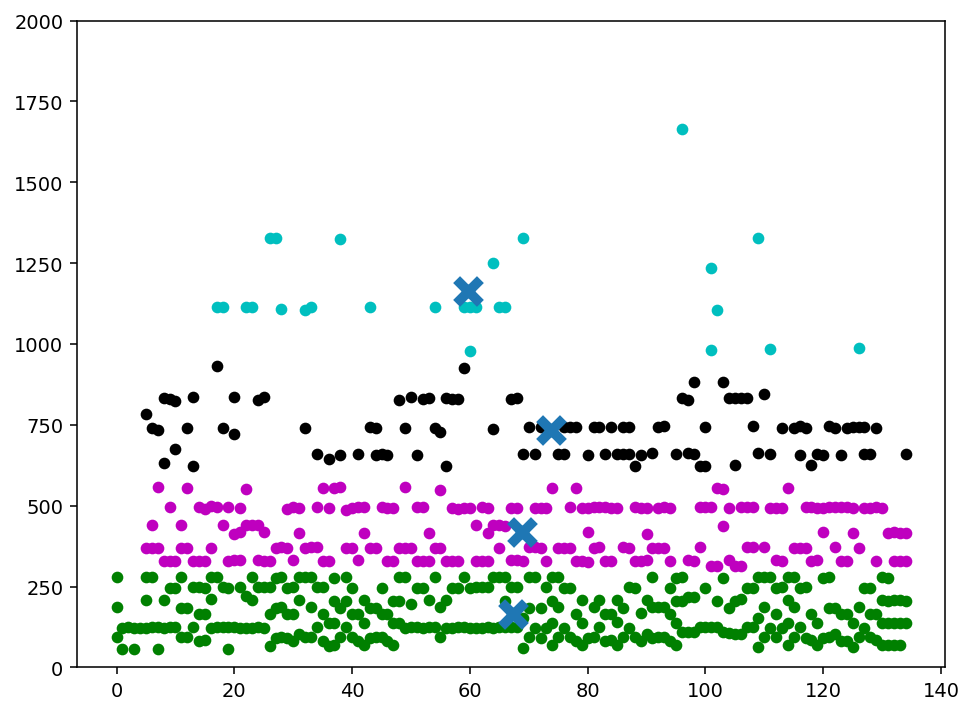

In [81]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Generar datos de ejemplo
X = np.array(constellation_map)

# Definir el número de clusters (k)
k = 6

# Inicializar el modelo K-Means
kmeans = KMeans(n_clusters=k)

# Ajustar el modelo a los datos
kmeans.fit(X)

# Obtener las ubicaciones de los centroides y las etiquetas de los clusters
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Mostrar los resultados
colors = ["g.", "r.", "c.", "y.", "k.", "m."]

for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize=10)
plt.ylim(0, 2000);
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=150, linewidths=5, zorder=10)
plt.show()



In [ ]:
ult_n_init=10)
